# UCF50 Human Activity Recognition (HAR) in Tensorflow

In this project we will implement Human Activity Recognition also called as HAR, for this we will be using the UCF50 Dataset provided by the University of Central Florida you can check the website over [here](https://www.crcv.ucf.edu/data/UCF50.php).

The dataset we are using contains 101 action categories, in a video file format. So the problem task comes down to a video classification problem. 
layer.   

## Importing Libraries

In [1]:
pip install tensorflow==2.16.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pytube

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import ssl
from urllib.request import urlretrieve
#import rarfile
import math
import time
import random
import numpy as np
import datetime as dt
from collections import deque
from sklearn.model_selection import train_test_split

import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, MaxPooling3D, MaxPooling2D, LSTM, TimeDistributed, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [5]:
# Setting seed for randomness
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [6]:
# Details on the downloaded data
UCF101_DATA_PATH=r"C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101"

for dirpath, dirnames, filenames in os.walk(UCF101_DATA_PATH):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}".')

There are 101 directories and 0 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101".
There are 0 directories and 145 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\ApplyEyeMakeup".
There are 0 directories and 114 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\ApplyLipstick".
There are 0 directories and 145 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\Archery".
There are 0 directories and 132 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\BabyCrawling".
There are 0 directories and 108 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\BalanceBeam".
There are 0 directories and 155 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\BandMarching".
There are 0 directories and 150 files in "C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\BaseballPitch".
There are 0 directories and 134 files in "C:\Users\dhanu\OneDrive\Deskt

In [7]:
CLASSES_LIST = ['Archery', 'Basketball', 'Biking', 'Bowling', 'CricketBowling','CricketShot', 'Diving', 'Fencing', 'GolfSwing', 'HighJump',
'HulaHoop', 'PlayingFlute', 'PlayingGuitar', 'PlayingViolin', 'PlayingCello','Skijet', 'SkyDiving', 'Skiing', 'Surfing', 'Typing','TableTennisShot', 'LongJump']

There are 101 different categories containing video files between the range of 100 and 200.

## Visualizing the dataset

Now that the data is downloaded, lets view the data with the labels.

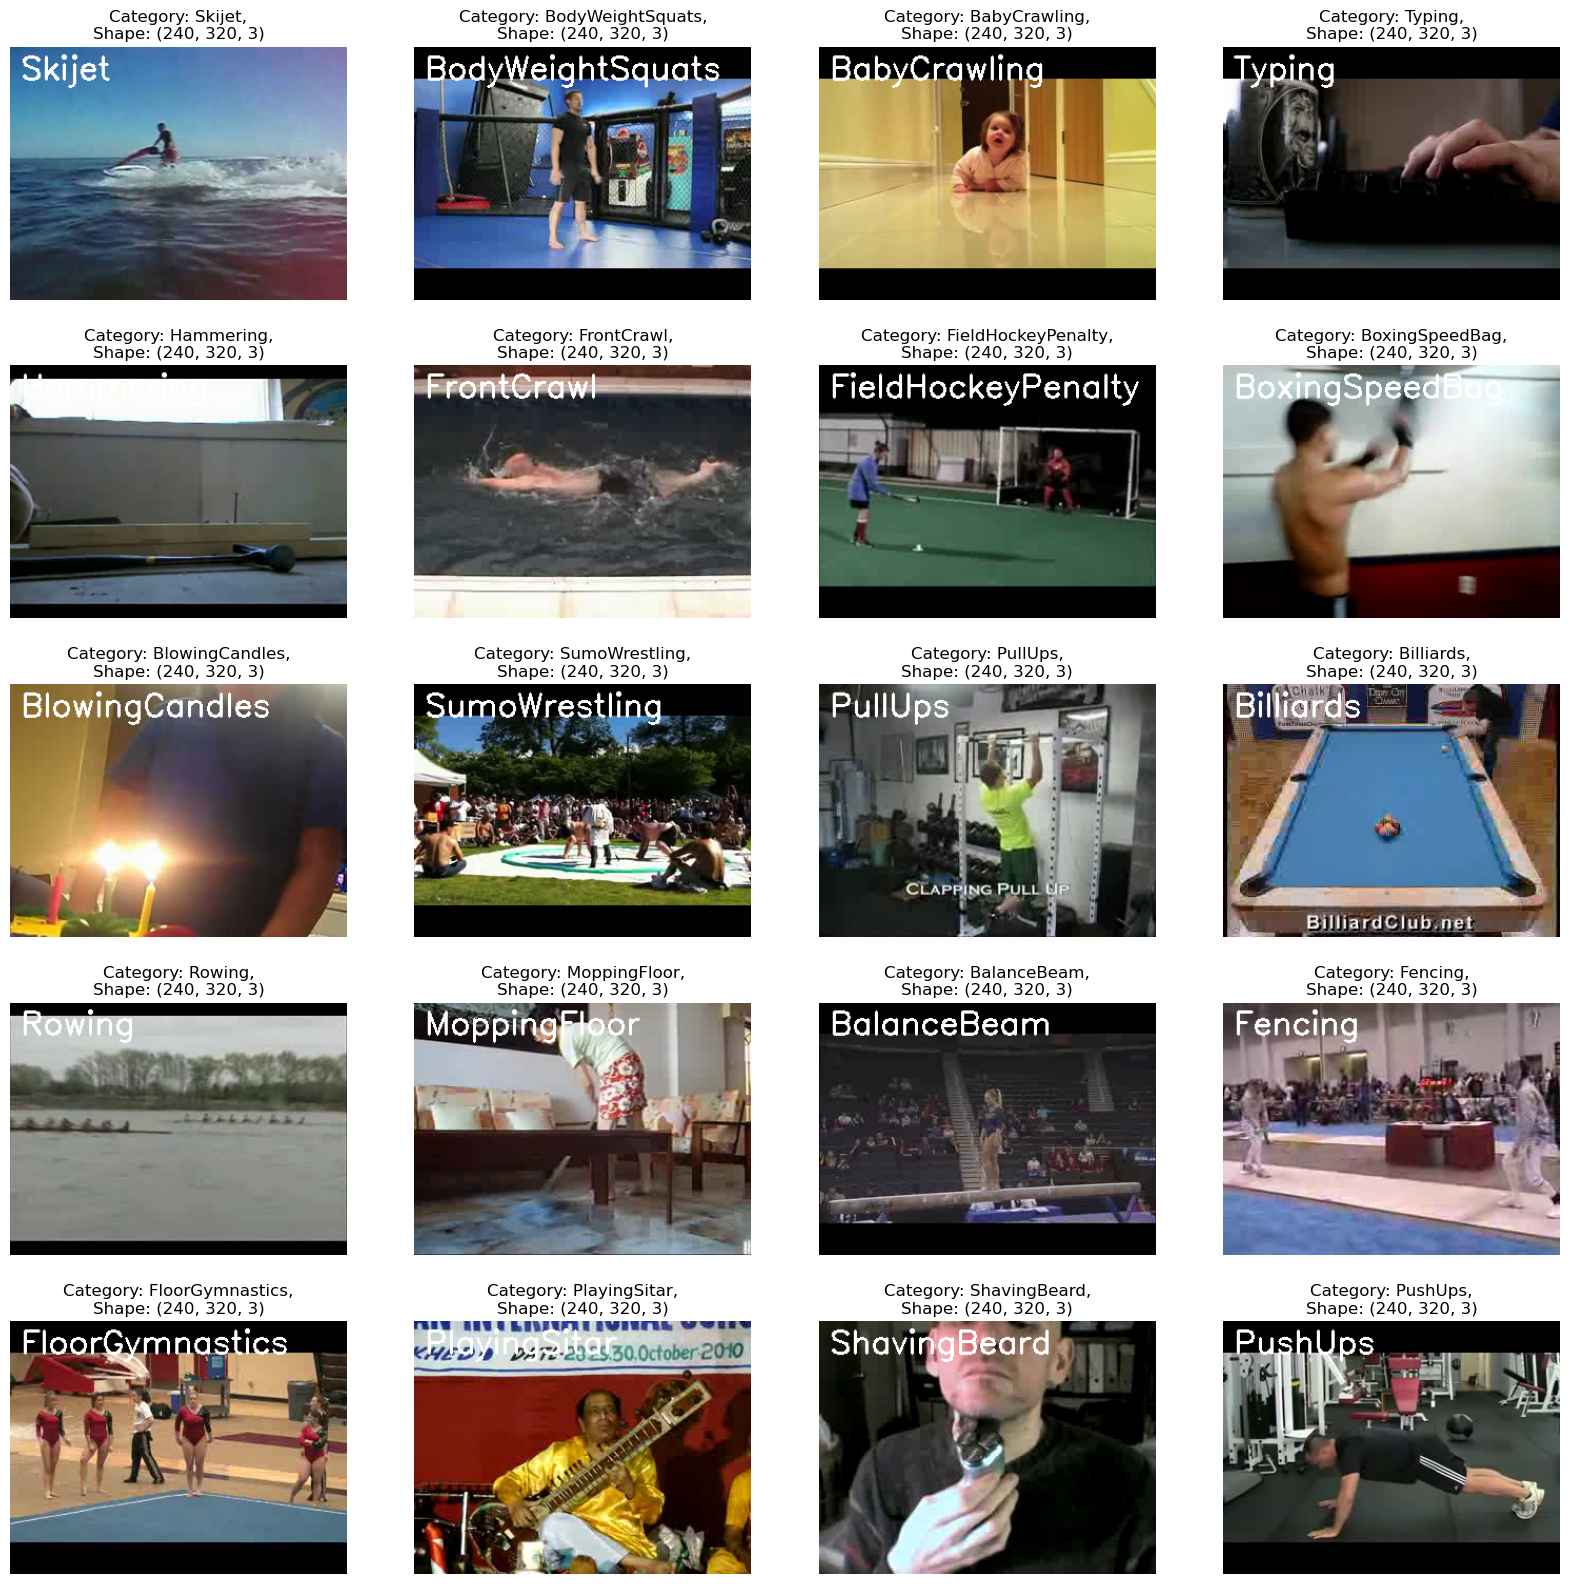

In [8]:
plt.figure(figsize=(20, 20))
classes = sorted(os.listdir(UCF101_DATA_PATH))

# Selecting 20 random categories for visualization
random_range = random.sample(range(len(classes)), 20)

for i, rand_i in enumerate(random_range, 1):
    class_name = classes[rand_i]

    # Looking for the video files in the category and selecting it randomly
    video_files_list = os.listdir(os.path.join(UCF101_DATA_PATH, class_name))
    video_file_name = random.choice(video_files_list)

    # Reading the video file and displaying the first frame with label.
    video_reader = cv2.VideoCapture(os.path.join(UCF101_DATA_PATH, class_name, video_file_name))
    _, frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, i)
    plt.title(f'Category: {class_name},\nShape: {rgb_frame.shape}')
    plt.imshow(rgb_frame)
    plt.axis(False);

## Preprocessing the Dataset

Now, that we have the data and have also visualized it, lets move to the preprocessing stage, in this stage we will perform following actions:
1. Select and extract frames from the video.
2. Resize the video frame to a certain size.
3. Normalize the frames from 0 to 255, between the range of 0 to 1.
4. Finally, create a dataset containing all the data.

In [9]:
# Defining variables
FRAME_HEIGHT, FRAME_WIDTH = 64, 64 # shape of the image
SEQUENCE_LENGTH = 10 # Frames feeded to the model as a single sequence
CLASSES_LIST = ['Archery', 'Basketball', 'Biking', 'Bowling', 'CricketBowling','CricketShot', 'Diving', 'Fencing', 'GolfSwing', 'HighJump',
'HulaHoop', 'PlayingFlute', 'PlayingGuitar', 'PlayingViolin', 'PlayingCello','Skijet', 'SkyDiving', 'Skiing', 'Surfing', 'Typing','TableTennisShot', 'LongJump']

In [10]:
len(CLASSES_LIST)

22

Now lets extract frames or images from that video and transform the size and normalize the images, while extracting the frames we will not be collecting all the images. 

Images will be collected at a interval and max images will be as per the sequence length we have set.

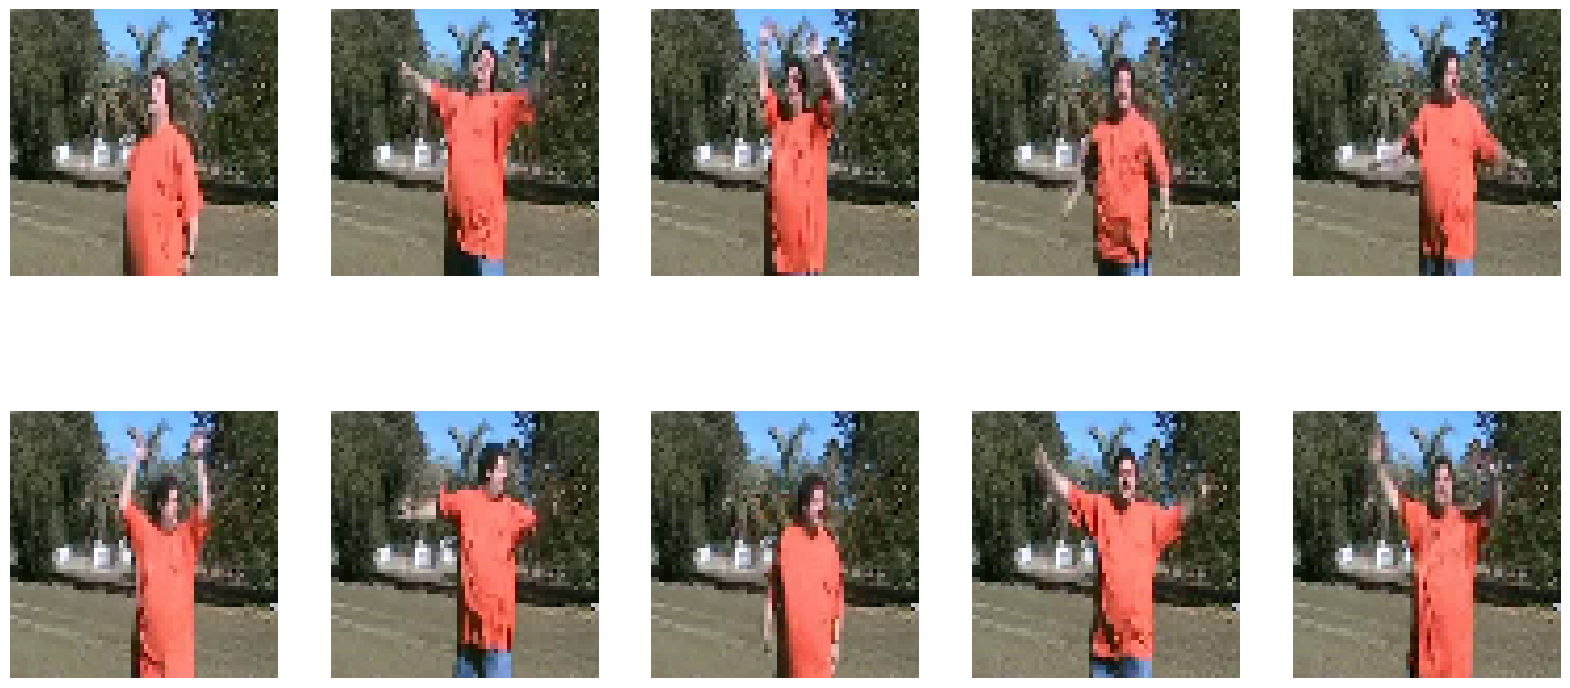

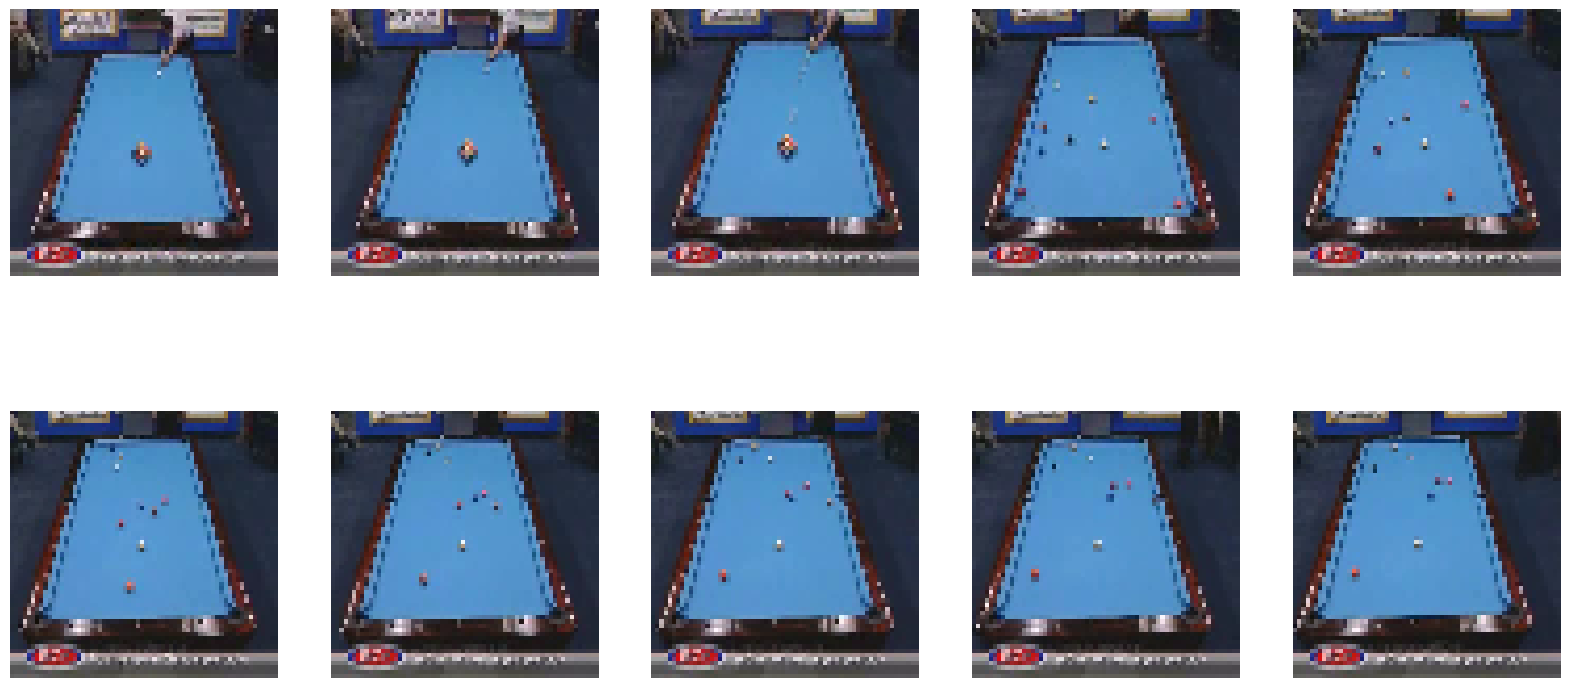

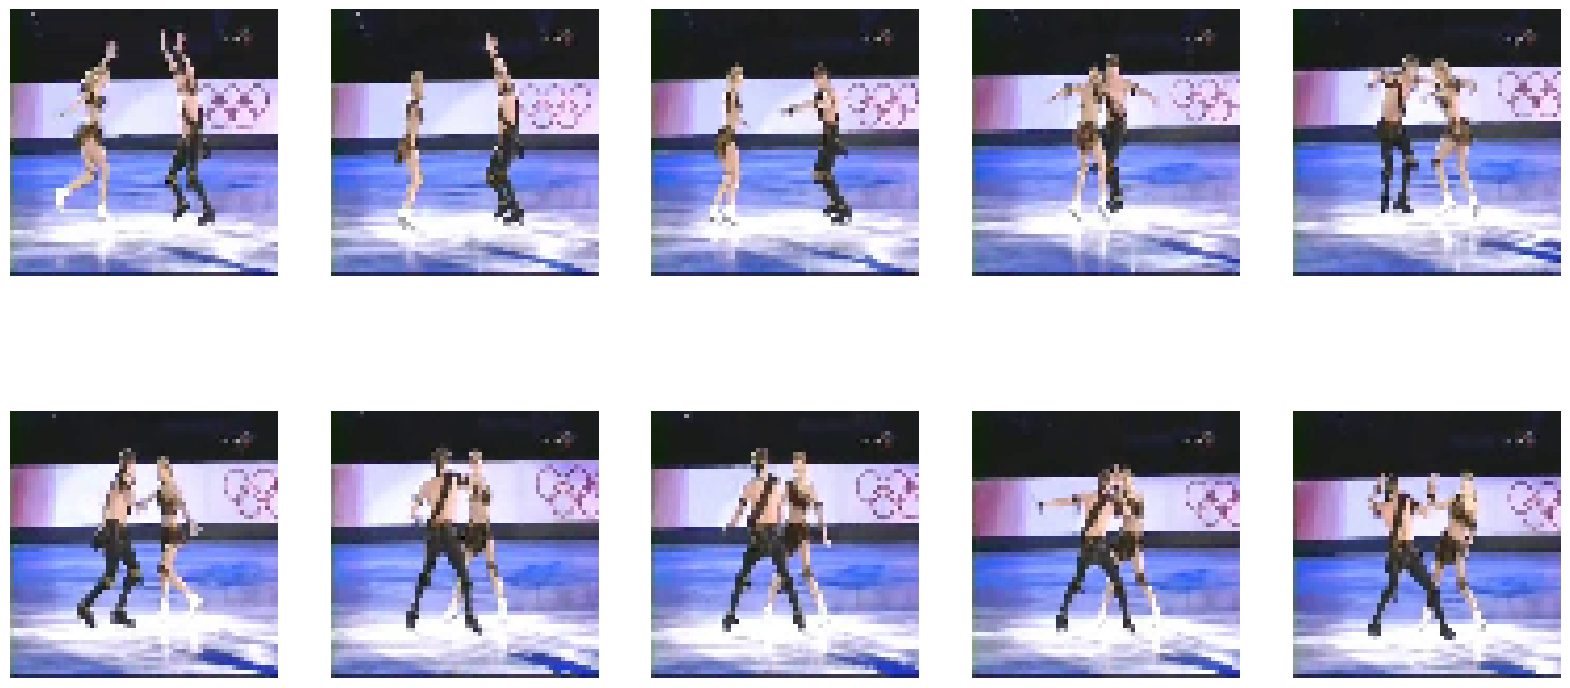

In [11]:
import os
import random

# Function to recursively search for video files
def find_video_files(directory):
    video_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".avi"):
                video_files.append(os.path.join(root, file))
    return video_files

# Get a list of video files in all subfolders
video_files = find_video_files(UCF101_DATA_PATH)

# Check if there are at least three videos
if len(video_files) < 5:
    print("There are not enough videos in the directory.")
else:
    # Choose three random videos
    random_videos = random.sample(video_files, 3)

    # Loop through the random videos
    for video_path in random_videos:
        frames_list = []
        video_reader = cv2.VideoCapture(video_path)
        video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames = max(int(video_frame_count/SEQUENCE_LENGTH), 1)
        for i in range(SEQUENCE_LENGTH):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
            success, frame = video_reader.read()
            if not success:
                break
            resize_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
            norm_frame = resize_frame / 255.
            frames_list.append(norm_frame)
        video_reader.release()

        # Display frames
        plt.figure(figsize=(20, 20))
        for i in range(SEQUENCE_LENGTH):
            plt.subplot(4, 5, i+1)
            plt.imshow(cv2.cvtColor(np.float32(frames_list[i]), cv2.COLOR_BGR2RGB))
            plt.axis(False)
        plt.show()


In [12]:
# frames_list = []
# video_reader = cv2.VideoCapture(r"C:\Users\Karthick\Downloads\UCF50 (1)\UCF50\Rowing\v_Rowing_g25_c04.avi")
# video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
# skip_frames = max(int(video_frame_count/SEQUENCE_LENGTH), 1)
# for i in range(SEQUENCE_LENGTH):
#     video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
#     success, frame = video_reader.read()
#     if not success:
#         break
#     resize_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
#     norm_frame = resize_frame / 255.
#     frames_list.append(norm_frame)
# video_reader.release()

# plt.figure(figsize=(20, 20))
# for i in range(SEQUENCE_LENGTH):
#     plt.subplot(4, 5, i+1)
#     plt.imshow(cv2.cvtColor(np.float32(frames_list[i]), cv2.COLOR_BGR2RGB))
#     plt.axis(False)

In [13]:
# Converting the above working as a function
def frames_extraction(video_path: str):
    """
    This function will extract frames at certain interval and apply transformation
    like resize and normalization and return all the frames in a list.

    Parameters: video_path: str, video file path in string format.

    Returns: frames_list: list, contains extracted and transformed frames.
    """
    frames_list = []
    # Reading the video file and counting the frames
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Selecting the frames at certain interval and applying the transformation
    skip_frames = max(int(video_frame_count/SEQUENCE_LENGTH), 1)
    for i in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
        success, frame = video_reader.read()
        if not success:
            break
        resize_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
        norm_frame = resize_frame/255.
        frames_list.append(norm_frame.astype('float32'))
    video_reader.release()
    return frames_list

In [14]:
# Creating a function to create a dataset containing all the data as per the classes_list.
def create_dataset(class_list: list):
    """
    This function will create a dataset containing the features, labels
    and video file path for all the videos.
    
    Parameters: class_list: list, A list containing the names of the video classes or category.
    
    Returns: features: A numpy array for all the extracted videos, 
             labels: A numpy array containing the classes in ordinal format,
             video_file_path: A list containing the path for all the videos.    
    """
    features = []
    labels = []
    video_files_path = []
    
    # Going through all the data in the class list
    for i, class_name in enumerate(class_list):
        print(f'[INFO] Extracting all the data in the class: {class_name}')

        # Getting the list of all the video files and the path to the video
        files_list = os.listdir(os.path.join(UCF101_DATA_PATH, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(UCF101_DATA_PATH, class_name, file_name)

            # Extracting frames using the function and verifying the total frames
            frames_list = frames_extraction(video_path=video_file_path)
            if len(frames_list) == SEQUENCE_LENGTH:

                # Appending the data in a list
                features.append(frames_list)
                labels.append(i)
                video_files_path.append(video_file_path)
    
    # Converting the list to array
    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels, video_files_path

In [15]:
features, labels, video_files_path = create_dataset(class_list = CLASSES_LIST)

[INFO] Extracting all the data in the class: Archery
[INFO] Extracting all the data in the class: Basketball
[INFO] Extracting all the data in the class: Biking
[INFO] Extracting all the data in the class: Bowling
[INFO] Extracting all the data in the class: CricketBowling
[INFO] Extracting all the data in the class: CricketShot
[INFO] Extracting all the data in the class: Diving
[INFO] Extracting all the data in the class: Fencing
[INFO] Extracting all the data in the class: GolfSwing
[INFO] Extracting all the data in the class: HighJump
[INFO] Extracting all the data in the class: HulaHoop
[INFO] Extracting all the data in the class: PlayingFlute
[INFO] Extracting all the data in the class: PlayingGuitar
[INFO] Extracting all the data in the class: PlayingViolin
[INFO] Extracting all the data in the class: PlayingCello
[INFO] Extracting all the data in the class: Skijet
[INFO] Extracting all the data in the class: SkyDiving
[INFO] Extracting all the data in the class: Skiing
[INFO] E

In [16]:
features.shape, labels.shape, video_files_path[:5]

((2979, 10, 64, 64, 3),
 (2979,),
 ['C:\\Users\\dhanu\\OneDrive\\Desktop\\Project_SemII\\UCF101\\UCF-101\\Archery\\v_Archery_g01_c01.avi',
  'C:\\Users\\dhanu\\OneDrive\\Desktop\\Project_SemII\\UCF101\\UCF-101\\Archery\\v_Archery_g01_c02.avi',
  'C:\\Users\\dhanu\\OneDrive\\Desktop\\Project_SemII\\UCF101\\UCF-101\\Archery\\v_Archery_g01_c03.avi',
  'C:\\Users\\dhanu\\OneDrive\\Desktop\\Project_SemII\\UCF101\\UCF-101\\Archery\\v_Archery_g01_c04.avi',
  'C:\\Users\\dhanu\\OneDrive\\Desktop\\Project_SemII\\UCF101\\UCF-101\\Archery\\v_Archery_g01_c05.avi'])

Now that the dataset created, lets convert the labels into OneHotEncoding format.

In [17]:
encoded_labels = to_categorical(labels)
encoded_labels.shape, encoded_labels[:5]

((2979, 22),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]]))

In [18]:
encoded_labels.shape, encoded_labels[-5:]

((2979, 22),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1.]]))

## Splitting and Configuring the Dataset

Now, that the dataset is been created and the labels are one hot encoded, we will split the dataset in training and testing dataset.

In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                                            encoded_labels, 
                                                                            test_size=0.25, 
                                                                            shuffle=True, 
                                                                            random_state=seed)

In [20]:
train_features.shape, train_labels.shape

((2234, 10, 64, 64, 3), (2234, 22))

In [21]:
test_features.shape, test_labels.shape

((745, 10, 64, 64, 3), (745, 22))

Now that the dataset is splitted, we can configure the dataset for performance by batching and prefetching the data.

In [22]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [23]:
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.float64, name=None))>)

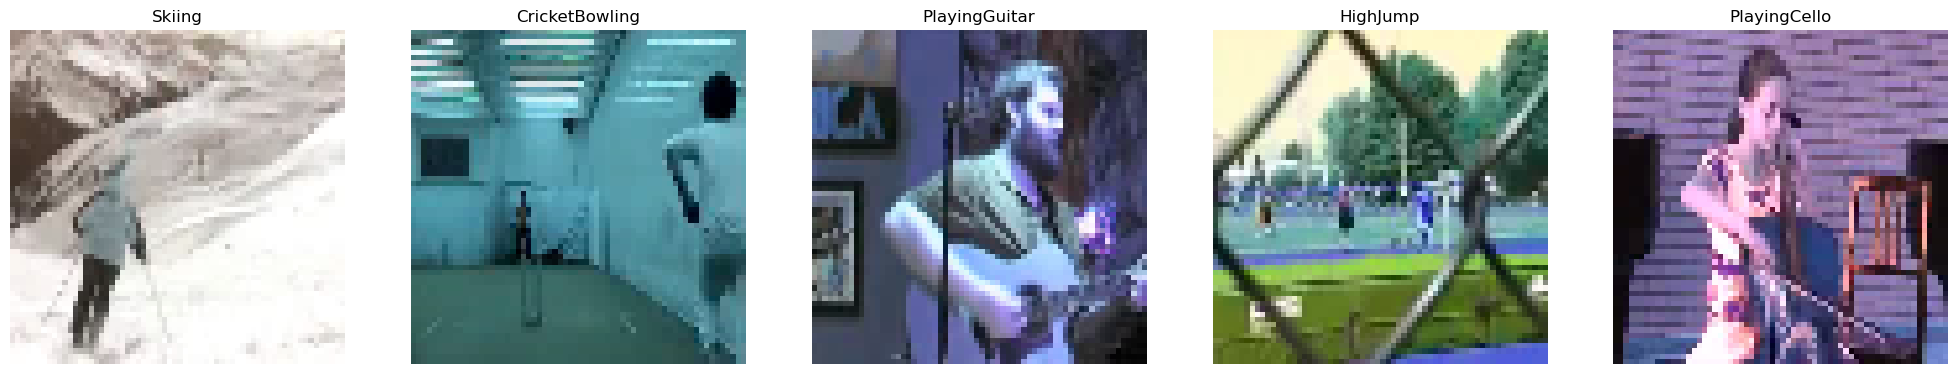

In [24]:
# Random testing the training dataset
plt.figure(figsize=(25, 5))
rand_test = next(iter(train_ds))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(rand_test[0][i][0])
    plt.title(CLASSES_LIST[rand_test[1][i].numpy().argmax()])
    plt.axis(False);

## Modeling

We will be creating two different architctures:
1. ConvLSTM
2. LRCN - Long Term Recurrent Convolutional Network

### Model 1 - ConvLSTM

In [25]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense, Input
)

class CreateConvlstmModel(Model):
    """
    Constructs and initiates a ConvLSTM model for video classification.

    Parameters: 
        input_shape: tuple, Input shape of the array fed into the model.
                     Format should be (timesteps, height, width, channels)
        num_classes: int, Total number of classes to predict.

    Returns: Fully constructed ConvLSTM model.
    """
    def __init__(self, input_shape: tuple, num_classes: int):
        super(CreateConvlstmModel, self).__init__()
        self.input_block1 = Sequential([
            Input(shape=input_shape),  # Explicit input shape
            ConvLSTM2D(4, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.2))
        ])
        self.block2 = Sequential([
            ConvLSTM2D(8, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.2))
        ])
        self.block3 = Sequential([
            ConvLSTM2D(12, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.2))
        ])
        self.block4 = Sequential([
            ConvLSTM2D(16, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last')
        ])
        self.classifier_block = Sequential([
            Flatten(),
            Dense(num_classes, activation='softmax')
        ])
    
    def call(self, x):
        x = self.input_block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier_block(x)

# Example usage
convlstm_model1 = CreateConvlstmModel(
    input_shape=(SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
)


#### Checking Model Structure

In [26]:
# Initialize model
convlstm_model1 = CreateConvlstmModel(
    input_shape=(SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
)

# Model is automatically built; display the summary
convlstm_model1.summary(expand_nested=True, show_trainable=True)


Model: "create_convlstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ sequential_5 (Sequential)             │ (None, 10, 31, 31, 4)         │          1,024 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ conv_lstm2d_4 (ConvLSTM2D)       │ (None, 10, 62, 62, 4)         │          1,024 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ max_pooling3d_4 (MaxPooling3D)   │ (None, 10, 31, 31, 4)         │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_3               │ (None, 10, 31, 31, 4)         │              0 │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_6 (Sequential)             │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ conv_lstm2d_5 (ConvLSTM2D)       │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ max_pooling3d_5 (MaxPooling3D)   │ ?                             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_4               │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_7 (Sequential)             │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ conv_lstm2d_6 (ConvLSTM2D)       │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ max_pooling3d_6 (MaxPooling3D)   │ ?                             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_5               │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_8 (Sequential)             │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ conv_lstm2d_7 (ConvLSTM2D)       │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ max_pooling3d_7 (MaxPooling3D)   │ ?                             │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_9 (Sequential)             │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ flatten_1 (Flatten)              │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼────────────────────

 Total params: 1,024 (4.00 KB)

 Trainable params: 1,024 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling and Training the Model

First we will setup the callback this will help in monitoring the metrics and help in reducing the over fitting.<br>
We will be using two callbacks they are as follows:
1. Tensorboard: This callback helps in tracking and logging the performance of the models, it helps in comparing the results of multiple models in a visual dashboard. 
2. EarlyStopping: This callback monitors the training for some certain amount of training steps, and when the model does not improve it will stop the training.
3. ReduceLROnPlateau: Similar to the early stopping, it monitors the model training and when there's no improvement, it will reduce the learning rate of the optimizer to some extend. 

After the callbacks are created, we will compile the model with all the necessary configurations and fit the model for a certain number of epochs.

In [27]:
# creating tensorboard and early stopping callbacks
def create_tensorboard_callback(dir_name: str, exp_name: str):
    log_dir = dir_name + '/' + exp_name + '/' + dt.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
    tensorboard_callabck = TensorBoard(log_dir=log_dir)
    print(f'[INFO] Saving Tensorboard log files to: {log_dir}')
    return tensorboard_callabck

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=20,
                                        mode='min',
                                        verbose=1,
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                       mode='min',
                                       factor=0.2,
                                       patience=10,
                                       verbose=1,
                                       min_lr=1e-7)

In [28]:
# Compiling the model
convlstm_model1.compile(loss='categorical_crossentropy', 
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fitting the model
start_time = time.time()
model1_history = convlstm_model1.fit(train_ds,
                                     epochs=30,
                                     steps_per_epoch=len(train_ds),
                                     validation_data=test_ds,
                                     validation_steps=len(test_ds),
                                     callbacks=[early_stopping_callback,
                                                reduce_lr_callback])
end_time = time.time()
training_time = end_time - start_time
print(f'\n[INFO] Total time taken to train the convlstm_model1 with early stopping:\nTotal Epochs: {len(model1_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.0740 - loss: 3.0023 - val_accuracy: 0.2671 - val_loss: 2.3775 - learning_rate: 0.0010
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2976 - loss: 2.2760 - val_accuracy: 0.3490 - val_loss: 2.0313 - learning_rate: 0.0010
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3790 - loss: 1.9130 - val_accuracy: 0.4268 - val_loss: 1.8062 - learning_rate: 0.0010
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.4850 - loss: 1.6624 - val_accuracy: 0.4779 - val_loss: 1.6904 - learning_rate: 0.0010
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5424 - loss: 1.4458 - val_accuracy: 0.5436 - val_loss: 1.4732 - learning_rate: 0.0010
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6045 - loss: 1.2716 - val_accuracy: 0.6268 - val_loss: 1.2750 - learning_rate: 0.0010
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 504s 7s/step - accuracy: 0.6943 - loss: 1.0132 - val_acc

#### Evaluate the Model

In [29]:
model1_eval_history = convlstm_model1.evaluate(test_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - accuracy: 0.8069 - loss: 0.7561


#### Saving the Model

In [34]:
import os
import datetime as dt

# Evaluate the model
model1_eval_history = convlstm_model1.evaluate(test_ds)
model1_eval_loss, model1_eval_accuracy = model1_eval_history

# Ensure the directory exists
os.makedirs("saved_model", exist_ok=True)

# Define the file name with colons replaced by underscores
model1_file_name = f"saved_model/convlstm_model1_{dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}_loss_{model1_eval_loss:.4f}_accuracy_{model1_eval_accuracy:.4f}.keras"

# Save the whole model with the .keras extension
convlstm_model1.save(model1_file_name)




24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.8069 - loss: 0.7561


#### Ploting Model Training Curves

In [35]:
def plot_model_curves(history, best_epoch: int=None):
    """ 
    Plots separate loss and accuracy curves for training and validation metrics.
    
    Parameters:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
        best_epoch: int(default: None), A integer for indicating the best epoch received during the model training by the early stopping callback.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(15, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

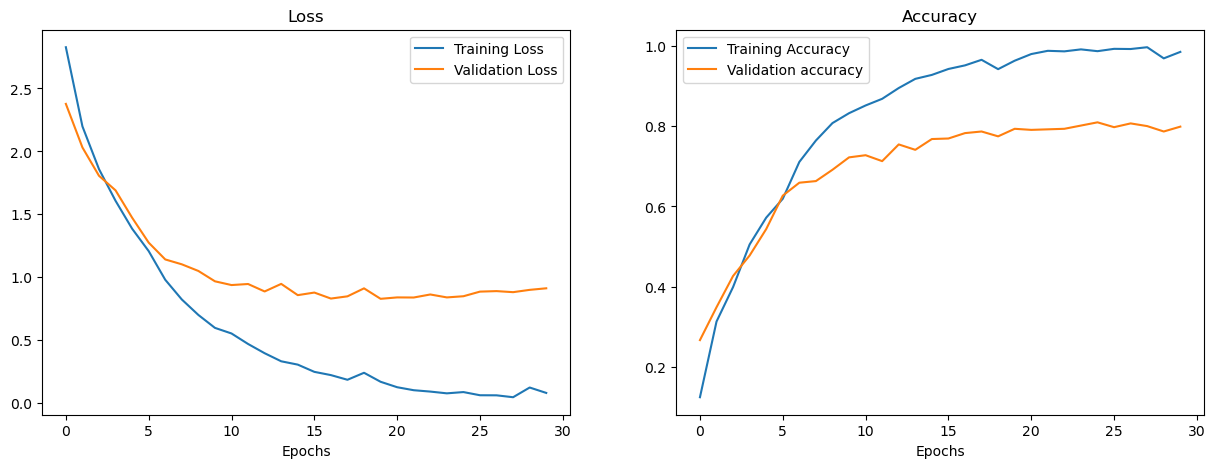

In [36]:
plot_model_curves(model1_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[24  3  3  0  0  0  0  0  0  0  0  2  0  0  2  0  0  0  0  0  0  0]
 

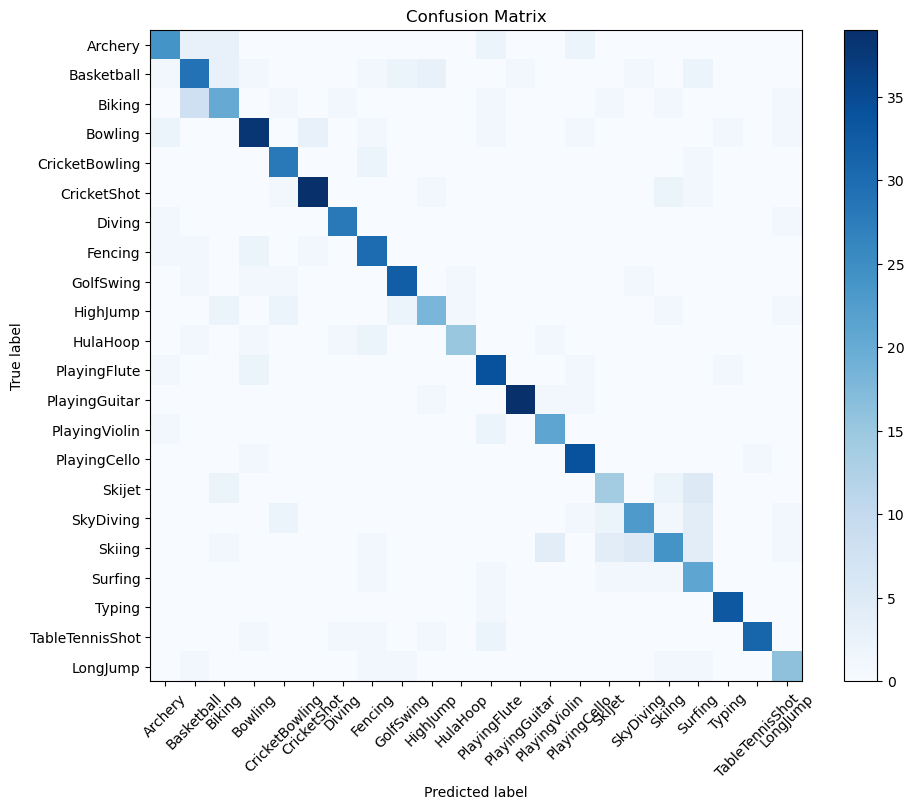

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred_batch = np.argmax(convlstm_model1.predict(x_batch), axis=1)  # Predicted labels
    y_pred.extend(y_pred_batch)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES_LIST))
plt.xticks(tick_marks, CLASSES_LIST, rotation=45)
plt.yticks(tick_marks, CLASSES_LIST)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [38]:
from sklearn.metrics import classification_report

# Assuming you have already calculated the true and predicted labels
# y_true and y_pred are the true and predicted labels respectively

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=CLASSES_LIST)

# Print classification report
print(class_report)

                 precision    recall  f1-score   support

        Archery       0.77      0.71      0.74        34
     Basketball       0.66      0.66      0.66        44
         Biking       0.65      0.59      0.62        34
        Bowling       0.81      0.79      0.80        48
 CricketBowling       0.80      0.90      0.85        31
    CricketShot       0.91      0.89      0.90        44
         Diving       0.90      0.93      0.92        30
        Fencing       0.75      0.86      0.80        35
      GolfSwing       0.86      0.86      0.86        37
       HighJump       0.75      0.67      0.71        27
       HulaHoop       0.88      0.71      0.79        21
   PlayingFlute       0.77      0.87      0.82        39
  PlayingGuitar       0.97      0.93      0.95        42
  PlayingViolin       0.78      0.88      0.82        24
   PlayingCello       0.85      0.94      0.89        36
         Skijet       0.64      0.61      0.62        23
      SkyDiving       0.74    

### Model 2 - LRCN

In [39]:
class CreateLRCNModel(Model):
    """
    Constructs and Initiates a LRCN model for video classification.

    Parameters: 
        input_shape: tuple, Input shape of the array that is feeded in the model.
                     Format of the input_shape should be (timesteps, height, width, channels)
        num_classes: int, Total number of classes that model needs to predict.

    Returns: Fully Constructed LRCN Model.
    """
    def __init__(self, input_shape: tuple, num_classes: int):
        super(CreateLRCNModel, self).__init__()
        self.input_block1 = Sequential([
            TimeDistributed(Conv2D(16, 3, padding='same', activation='relu'), input_shape=input_shape),
            TimeDistributed(MaxPooling2D(4)),
            TimeDistributed(Dropout(0.25))
        ])
        self.block2 = Sequential([
            TimeDistributed(Conv2D(32, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(4)),
            TimeDistributed(Dropout(0.25))
        ])
        self.block3 = Sequential([
            TimeDistributed(Conv2D(64, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2)),
            TimeDistributed(Dropout(0.25))
        ])
        self.block4 = Sequential([
            TimeDistributed(Conv2D(64, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2))
        ])
        self.classifier_block = Sequential([
            TimeDistributed(Flatten()),
            LSTM(32),
            Dense(num_classes, activation='softmax')
        ])
        
    def call(self, x):
        x = self.input_block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier_block(x)

lrcn_model2 = CreateLRCNModel(input_shape=(SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3), num_classes=len(CLASSES_LIST))

C:\Anaconda\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Checking Model Structure

In [40]:
lrcn_model2.build(input_shape=(BATCH_SIZE, SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3))
lrcn_model2.summary(expand_nested=True, show_trainable=True)

C:\Anaconda\Lib\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'create_lrcn_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "create_lrcn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ sequential_10 (Sequential)            │ (None, 10, 16, 16, 16)        │            448 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_6               │ (None, 10, 64, 64, 16)        │            448 │    Y    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_7               │ (None, 10, 16, 16, 16)        │              0 │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_8               │ (None, 10, 16, 16, 16)        │              0 │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_11 (Sequential)            │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_9               │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_10              │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_11              │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_12 (Sequential)            │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_12              │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_13              │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_14              │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ sequential_13 (Sequential)            │ ?                             │    0 (unbuilt) │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│    └ time_distributed_15              │ ?                             │    0 (unbuilt) │    -    │
│ (TimeDistributed)                     │                    

 Total params: 448 (1.75 KB)

 Trainable params: 448 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling and Training the Model

Similar to the above model we will compile the model and train it for some certain number of epochs and also customize the training behaviour using the previously initiated callbacks.

In [41]:
import os
from datetime import datetime

# Define the directory for TensorBoard logs
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f'training_logs/lrcn_model2/{timestamp}'

# Create the directory if it doesn't exist
os.makedirs(log_dir, exist_ok=True)

# Compiling the model
lrcn_model2.compile(loss='categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Fitting the model
start_time = time.time()
model2_history = lrcn_model2.fit(train_ds,
                                 epochs=100,
                                 steps_per_epoch=len(train_ds),
                                 validation_data=test_ds,
                                 validation_steps=len(test_ds),
                                 callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir),
                                            early_stopping_callback,
                                            reduce_lr_callback])
end_time = time.time()
training_time = end_time - start_time
print(f'\n[INFO] Total time taken to train the lrcn_model2 with early stopping:\nTotal Epochs: {len(model2_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.0605 - loss: 3.0763 - val_accuracy: 0.1087 - val_loss: 2.9649 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1569 - loss: 2.7225 - val_accuracy: 0.2027 - val_loss: 2.5372 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.2477 - loss: 2.4313 - val_accuracy: 0.2953 - val_loss: 2.2930 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.3185 - loss: 2.1686 - val_accuracy: 0.3477 - val_loss: 2.0790 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3855 - loss: 1.9756 - val_accuracy: 0.3638 - val_loss: 2.0528 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4664 - loss: 1.7816 - val_accuracy: 0.4282 - val_loss: 1.7566 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 817ms/step - accuracy: 0.5416 - loss: 1.5467 - 

#### Evaluate the Model

In [42]:
model2_eval_history = lrcn_model2.evaluate(test_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9152 - loss: 0.3439


#### Saving the Model

In [54]:
import os
import datetime as dt
from tensorflow.keras.models import Model
import time

# Define the directory for saving the model
save_dir = "saved_model"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Evaluate the model
model2_eval_history = lrcn_model2.evaluate(test_ds)
model2_eval_loss, model2_eval_accuracy = model2_eval_history

# Construct the file name dynamically with valid extensions
model2_file_name = os.path.join(
    save_dir,
    f"lrcn_model2_loss_{model2_eval_loss:.4f}_accuracy_{model2_eval_accuracy:.4f}.keras"
)

# Save the model using the .keras extension
lrcn_model2.save(model2_file_name)

print(f"Model saved successfully to: {model2_file_name}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9152 - loss: 0.3439
Model saved successfully to: saved_model\lrcn_model2_loss_0.3953_accuracy_0.9074.keras


Note: The above warning can be ignored, this type of warnings are present in the documentation of the tensorflow api.

#### Ploting Model Training Curves

We will use the same function we had created earlier for the ConvLSTM Model and plot the loss and accuracy curves of the LRCN Model.

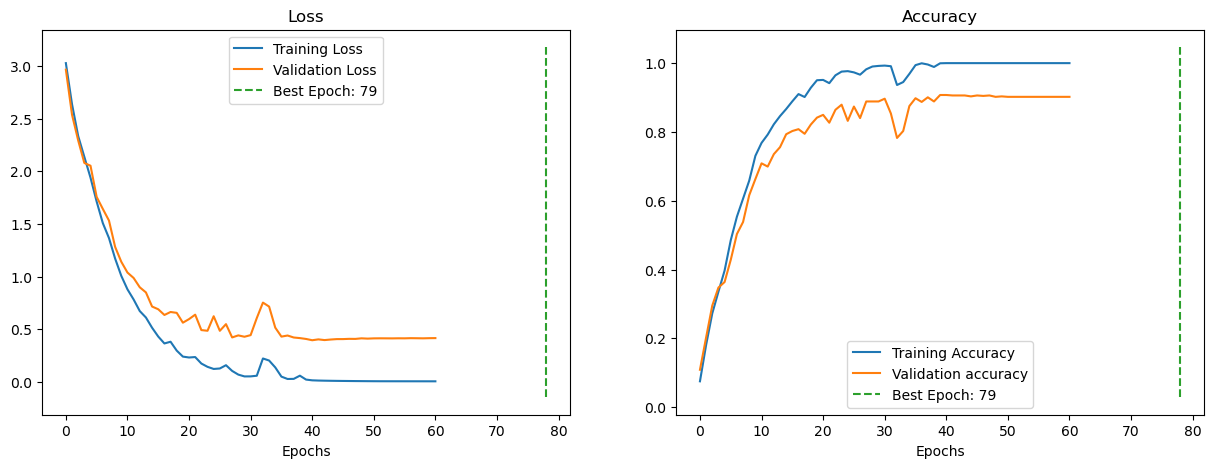

In [55]:
plot_model_curves(history=model2_history, best_epoch=79)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
[[31  0  1  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2 37  1  0

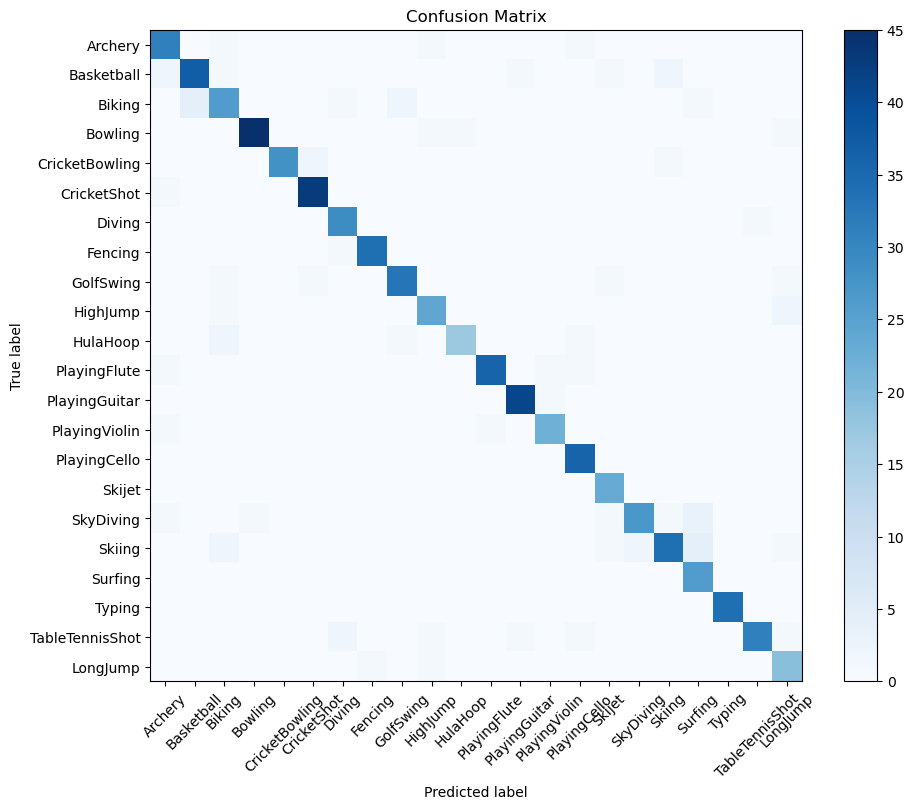

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred_batch = np.argmax(lrcn_model2.predict(x_batch), axis=1)  # Predicted labels
    y_pred.extend(y_pred_batch)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES_LIST))
plt.xticks(tick_marks, CLASSES_LIST, rotation=45)
plt.yticks(tick_marks, CLASSES_LIST)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [57]:
from sklearn.metrics import classification_report

# Assuming you have already calculated the true and predicted labels
# y_true and y_pred are the true and predicted labels respectively

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=CLASSES_LIST)

# Print classification report
print(class_report)


                 precision    recall  f1-score   support

        Archery       0.84      0.91      0.87        34
     Basketball       0.90      0.84      0.87        44
         Biking       0.76      0.76      0.76        34
        Bowling       0.98      0.94      0.96        48
 CricketBowling       1.00      0.90      0.95        31
    CricketShot       0.93      0.98      0.96        44
         Diving       0.88      0.97      0.92        30
        Fencing       0.97      0.97      0.97        35
      GolfSwing       0.92      0.89      0.90        37
       HighJump       0.86      0.89      0.87        27
       HulaHoop       0.94      0.81      0.87        21
   PlayingFlute       0.97      0.92      0.95        39
  PlayingGuitar       0.95      0.98      0.96        42
  PlayingViolin       0.92      0.92      0.92        24
   PlayingCello       0.90      1.00      0.95        36
         Skijet       0.85      1.00      0.92        23
      SkyDiving       0.93    

In [66]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Sequential

class CreateTCNModel(Model):
    """
    Constructs and Initiates a TCN model for video classification.

    Parameters: 
        input_shape: tuple, Input shape of the array that is fed into the model.
                     Format of the input_shape should be (timesteps, height, width, channels)
        num_classes: int, Total number of classes that the model needs to predict.

    Returns: Fully Constructed TCN Model.
    """
    def __init__(self, input_shape: tuple, num_classes: int):
        super(CreateTCNModel, self).__init__()
        
        # Temporal Convolutional Blocks (time-distributed Conv2D layers)
        self.input_block1 = Sequential([
            TimeDistributed(Conv2D(16, 3, padding='same', activation='relu'), input_shape=input_shape),
            TimeDistributed(MaxPooling2D(2)),
            TimeDistributed(Dropout(0.25)),
            TimeDistributed(BatchNormalization())
        ])
        
        self.block2 = Sequential([
            TimeDistributed(Conv2D(32, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2)),
            TimeDistributed(Dropout(0.25)),
            TimeDistributed(BatchNormalization())
        ])
        
        self.block3 = Sequential([
            TimeDistributed(Conv2D(64, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2)),
            TimeDistributed(Dropout(0.25)),
            TimeDistributed(BatchNormalization())
        ])
        
        # Temporal convolutions (dilated convolutions)
        self.temporal_conv_block = Sequential([
            TimeDistributed(Conv2D(128, 3, dilation_rate=2, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2)),
            TimeDistributed(Dropout(0.25)),
            TimeDistributed(BatchNormalization())
        ])
        
        # Fully connected layers
        self.classifier_block = Sequential([
            TimeDistributed(Flatten()),
            LSTM(32),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
    
    def call(self, x):
        x = self.input_block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.temporal_conv_block(x)
        return self.classifier_block(x)

# Example usage:
input_shape = (SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3)  # Example input shape for videos
num_classes = len(CLASSES_LIST)  # Total number of classes

# Instantiate the TCN model
tcn_model = CreateTCNModel(input_shape=input_shape, num_classes=num_classes)

# Compile the model
tcn_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

# Summary of the model
tcn_model.summary()


C:\Anaconda\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "create_tcn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)           │ (None, 10, 32, 32, 16)      │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_17 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_18 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 512 (2.00 KB)

 Trainable params: 480 (1.88 KB)

 Non-trainable params: 32 (128.00 B)

In [67]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

# Define Early Stopping and Reduce Learning Rate callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Define the directory for TensorBoard logs
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f'training_logs/tcn_model/{timestamp}'

# Create the directory if it doesn't exist
os.makedirs(log_dir, exist_ok=True)

# Compile the TCN model
tcn_model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(),
                  metrics=['accuracy'])

# Fitting the model
start_time = time.time()
tcn_model_history = tcn_model.fit(train_ds,
                                  epochs=100,
                                  steps_per_epoch=len(train_ds),
                                  validation_data=test_ds,
                                  validation_steps=len(test_ds),
                                  callbacks=[TensorBoard(log_dir=log_dir),
                                             early_stopping_callback,
                                             reduce_lr_callback])
end_time = time.time()
training_time = end_time - start_time

print(f'\n[INFO] Total time taken to train the tcn_model with early stopping:\nTotal Epochs: {len(tcn_model_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.0703 - loss: 3.0448 - val_accuracy: 0.1852 - val_loss: 2.6772 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2382 - loss: 2.4950 - val_accuracy: 0.3221 - val_loss: 2.2202 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3621 - loss: 2.0889 - val_accuracy: 0.3812 - val_loss: 1.9531 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4529 - loss: 1.7666 - val_accuracy: 0.4738 - val_loss: 1.7378 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5391 - loss: 1.5116 - val_accuracy: 0.5101 - val_loss: 1.5740 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6463 - loss: 1.2008 - val_accuracy: 0.6268 - val_loss: 1.2550 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7542 - loss: 0.9155 - val_ac

In [68]:
# Evaluate the model
model_eval_history = tcn_model.evaluate(test_ds)
model_eval_loss, model_eval_accuracy = model_eval_history

# Ensure the directory exists
save_dir = "saved_model"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Construct the file name dynamically with valid extensions
model_file_name = os.path.join(
    save_dir,
    f"tcn_model_loss_{model_eval_loss:.4f}_accuracy_{model_eval_accuracy:.4f}.keras"  # Save as .keras
)

# Save the model using the .keras extension
tcn_model.save(model_file_name)

print(f"Model saved successfully to: {model_file_name}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9113 - loss: 0.3954
Model saved successfully to: saved_model\tcn_model_loss_0.4044_accuracy_0.9074.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Confusion Matrix:
[[31  0  0  0  0  0  0  0  0  0  0  0  1  0  2

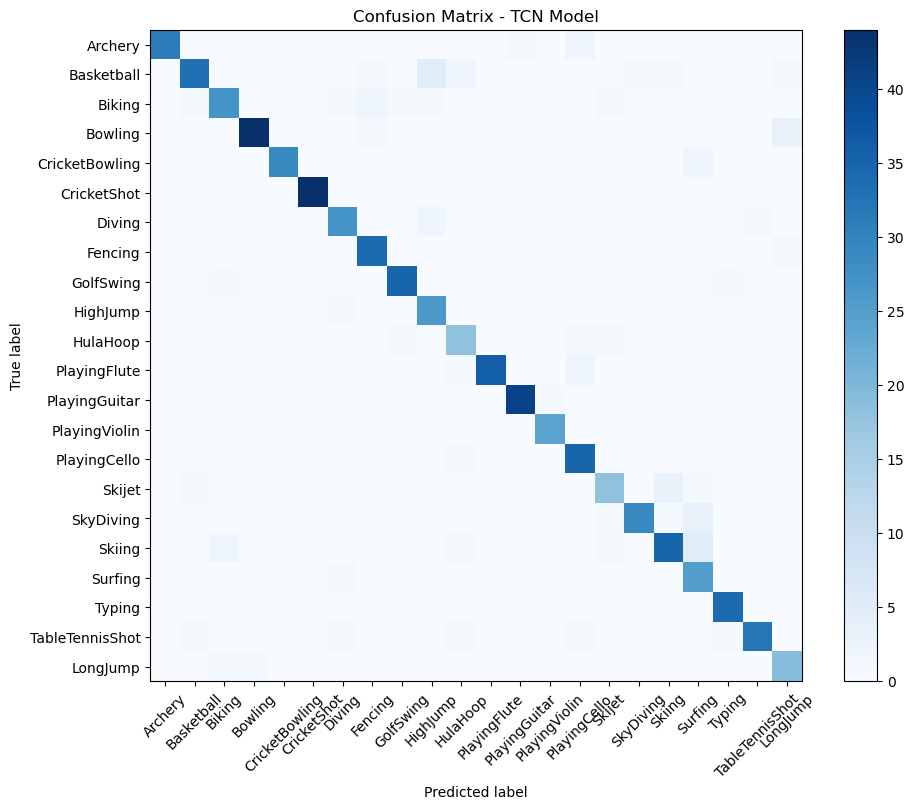

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the TCN model on the test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred_batch = np.argmax(tcn_model.predict(x_batch), axis=1)  # Predicted labels for TCN model
    y_pred.extend(y_pred_batch)

# Generate confusion matrix for TCN model
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix for TCN model
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - TCN Model')
plt.colorbar()
tick_marks = np.arange(len(CLASSES_LIST))
plt.xticks(tick_marks, CLASSES_LIST, rotation=45)
plt.yticks(tick_marks, CLASSES_LIST)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Generate classification report for TCN model


In [72]:
from sklearn.metrics import confusion_matrix, classification_report
class_report = classification_report(y_true, y_pred, target_names=CLASSES_LIST)

# Print classification report for TCN model
print("\nClassification Report:")
print(class_report)



Classification Report:
                 precision    recall  f1-score   support

        Archery       1.00      0.91      0.95        34
     Basketball       0.92      0.75      0.82        44
         Biking       0.87      0.79      0.83        34
        Bowling       0.98      0.92      0.95        48
 CricketBowling       1.00      0.94      0.97        31
    CricketShot       1.00      1.00      1.00        44
         Diving       0.87      0.90      0.89        30
        Fencing       0.89      0.97      0.93        35
      GolfSwing       0.95      0.95      0.95        37
       HighJump       0.76      0.96      0.85        27
       HulaHoop       0.75      0.86      0.80        21
   PlayingFlute       1.00      0.92      0.96        39
  PlayingGuitar       0.98      0.98      0.98        42
  PlayingViolin       0.96      1.00      0.98        24
   PlayingCello       0.85      0.97      0.91        36
         Skijet       0.82      0.78      0.80        23
      

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_gru_model(input_shape, num_classes):
    """
    Create a CNN-GRU model for video classification.
    
    Arguments:
        input_shape (tuple): Shape of the input data (timesteps, height, width, channels).
        num_classes (int): Number of classes to classify.
        
    Returns:
        model: The CNN-GRU model.
    """
    model = models.Sequential()
    
    # TimeDistributed CNN Backbone for spatial feature extraction
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    
    # Flatten the CNN output for temporal modeling
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    # Temporal Modeling using GRU
    model.add(layers.GRU(64, return_sequences=False))  # GRU layer
    
    # Fully Connected Layer for final classification
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def create_cnn_bilstm_model(input_shape, num_classes):
    """
    Create a CNN-BiLSTM model for video classification.
    
    Arguments:
        input_shape (tuple): Shape of the input data (timesteps, height, width, channels).
        num_classes (int): Number of classes to classify.
        
    Returns:
        model: The CNN-BiLSTM model.
    """
    model = models.Sequential()
    
    # TimeDistributed CNN Backbone for spatial feature extraction
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    
    # Flatten the CNN output for temporal modeling
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    # Temporal Modeling using BiLSTM
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))  # BiLSTM layer
    
    # Fully Connected Layer for final classification
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [78]:
# Define input shape and number of classes
input_shape = (SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3)  # Modify according to your data
num_classes = len(CLASSES_LIST)  # Define number of classes based on your dataset

# Create and train CNN-GRU model
cnn_gru_model = create_cnn_gru_model(input_shape, num_classes)
cnn_gru_model.summary()

# Training the model
cnn_gru_history = cnn_gru_model.fit(train_ds,
                                    epochs=100,
                                    validation_data=test_ds,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# Create and train CNN-BiLSTM model
cnn_bilstm_model = create_cnn_bilstm_model(input_shape, num_classes)
cnn_bilstm_model.summary()

cnn_bilstm_history = cnn_bilstm_model.fit(train_ds,
                                          epochs=100,
                                          validation_data=test_ds,
                                          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])


C:\Anaconda\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_35                  │ (None, 10, 62, 62, 32)      │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 10, 31, 31, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 10, 29, 29, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 10, 14, 14, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, 10, 12, 12, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, 10, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 10, 4608)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │         897,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 22)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,001,814 (3.82 MB)

 Trainable params: 1,001,814 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.0779 - loss: 3.0358 - val_accuracy: 0.2255 - val_loss: 2.5094
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3090 - loss: 2.2459 - val_accuracy: 0.4295 - val_loss: 1.8935
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5232 - loss: 1.6021 - val_accuracy: 0.6027 - val_loss: 1.3333
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7351 - loss: 0.9794 - val_accuracy: 0.7329 - val_loss: 0.9663
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8532 - loss: 0.6002 - val_accuracy: 0.7799 - val_loss: 0.7980
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9214 - loss: 0.3461 - val_accuracy: 0.8282 - val_loss: 0.6434
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9566 - loss: 0.2022 - val_accuracy: 0.8443 - val_loss: 0.5660
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9845 - loss: 0.0995 - val_accuracy: 0.

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_42                  │ (None, 10, 62, 62, 32)      │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, 10, 31, 31, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 10, 29, 29, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_45                  │ (None, 10, 14, 14, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_46                  │ (None, 10, 12, 12, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_47                  │ (None, 10, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_48                  │ (None, 10, 4608)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │       2,392,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 22)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,505,174 (9.56 MB)

 Trainable params: 2,505,174 (9.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.0976 - loss: 2.9509 - val_accuracy: 0.2148 - val_loss: 2.5951
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.2895 - loss: 2.3085 - val_accuracy: 0.3611 - val_loss: 2.0499
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4903 - loss: 1.7370 - val_accuracy: 0.5906 - val_loss: 1.3939
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6728 - loss: 1.1000 - val_accuracy: 0.6859 - val_loss: 1.1714
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8444 - loss: 0.6155 - val_accuracy: 0.8067 - val_loss: 0.7082
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9152 - loss: 0.3487 - val_accuracy: 0.8389 - val_loss: 0.6021
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9641 - loss: 0.1625 - val_accuracy: 0.8510 - val_loss: 0.5359
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9822 - loss: 0.0795 - val_accuracy: 0.

In [79]:
# Saving the CNN-GRU model
cnn_gru_model.save('cnn_gru_model.h5')
print("CNN-GRU Model saved successfully.")

# Saving the CNN-BiLSTM model
cnn_bilstm_model.save('cnn_bilstm_model.h5')
print("CNN-BiLSTM Model saved successfully.")


CNN-GRU Model saved successfully.
CNN-BiLSTM Model saved successfully.


In [80]:
# Evaluating the CNN-GRU model on the test data
cnn_gru_loss, cnn_gru_accuracy = cnn_gru_model.evaluate(test_ds)
print(f"CNN-GRU Model Loss: {cnn_gru_loss:.4f}")
print(f"CNN-GRU Model Accuracy: {cnn_gru_accuracy:.4f}")

# Evaluating the CNN-BiLSTM model on the test data
cnn_bilstm_loss, cnn_bilstm_accuracy = cnn_bilstm_model.evaluate(test_ds)
print(f"CNN-BiLSTM Model Loss: {cnn_bilstm_loss:.4f}")
print(f"CNN-BiLSTM Model Accuracy: {cnn_bilstm_accuracy:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.8880 - loss: 0.4636
CNN-GRU Model Loss: 0.5211
CNN-GRU Model Accuracy: 0.8779
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9009 - loss: 0.3960
CNN-BiLSTM Model Loss: 0.4528
CNN-BiLSTM Model Accuracy: 0.8899


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CNN-GRU Confusion Matrix:
[[30  0  0  1  0  0  0  0  0  0  1  0  1  0 

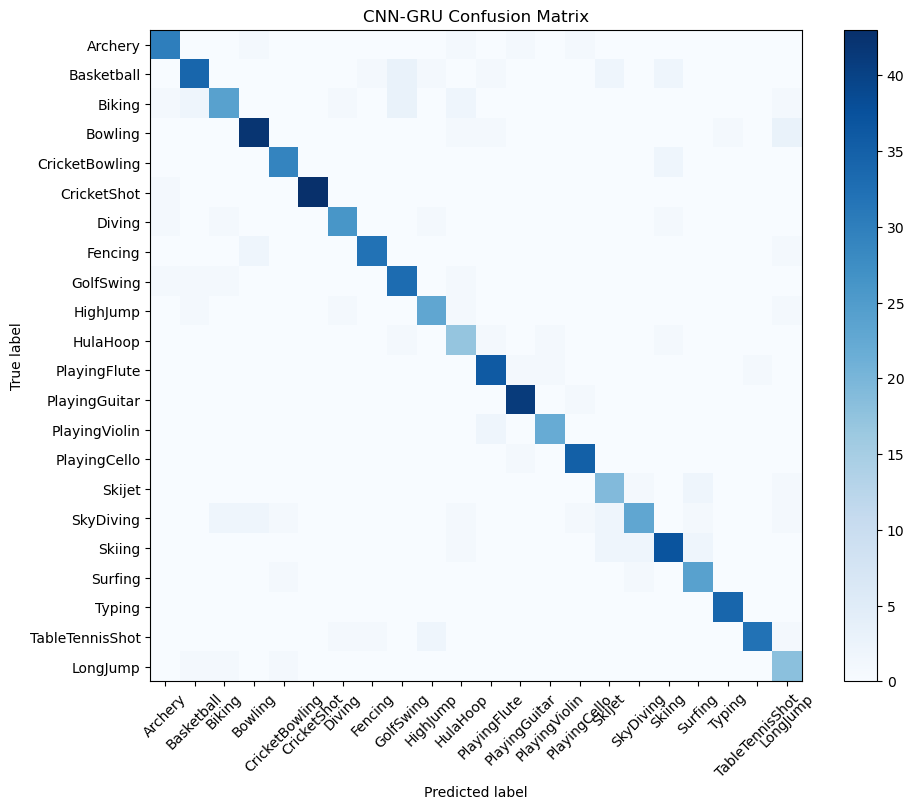

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CNN-BiLSTM Confusion Matrix:
[[31  0  0  1  0  0  0  0  0  0  1  0  0 

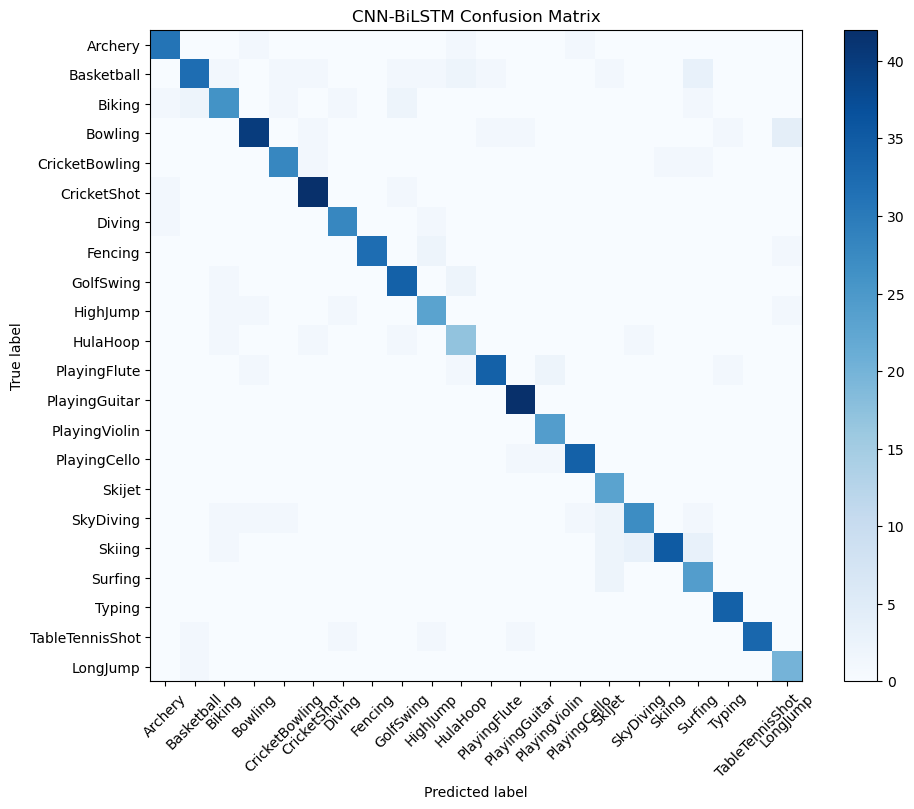

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluate the CNN-GRU model on the test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred_batch = np.argmax(cnn_gru_model.predict(x_batch), axis=1)  # Predicted labels
    y_pred.extend(y_pred_batch)

# Generate confusion matrix for CNN-GRU
cm_gru = confusion_matrix(y_true, y_pred)
print("CNN-GRU Confusion Matrix:")
print(cm_gru)

# Plot confusion matrix for CNN-GRU
plt.figure(figsize=(10, 8))
plt.imshow(cm_gru, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN-GRU Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES_LIST))
plt.xticks(tick_marks, CLASSES_LIST, rotation=45)
plt.yticks(tick_marks, CLASSES_LIST)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Repeat the process for CNN-BiLSTM
y_true_bilstm = []
y_pred_bilstm = []

for x_batch, y_batch in test_ds:
    y_true_bilstm.extend(np.argmax(y_batch, axis=1))  # True labels
    y_pred_batch_bilstm = np.argmax(cnn_bilstm_model.predict(x_batch), axis=1)  # Predicted labels
    y_pred_bilstm.extend(y_pred_batch_bilstm)

# Generate confusion matrix for CNN-BiLSTM
cm_bilstm = confusion_matrix(y_true_bilstm, y_pred_bilstm)
print("CNN-BiLSTM Confusion Matrix:")
print(cm_bilstm)

# Plot confusion matrix for CNN-BiLSTM
plt.figure(figsize=(10, 8))
plt.imshow(cm_bilstm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN-BiLSTM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES_LIST))
plt.xticks(tick_marks, CLASSES_LIST, rotation=45)
plt.yticks(tick_marks, CLASSES_LIST)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [82]:
from sklearn.metrics import classification_report

# Classification report for CNN-GRU model
class_report_gru = classification_report(y_true, y_pred, target_names=CLASSES_LIST)
print("CNN-GRU Classification Report:")
print(class_report_gru)

# Classification report for CNN-BiLSTM model
class_report_bilstm = classification_report(y_true_bilstm, y_pred_bilstm, target_names=CLASSES_LIST)
print("CNN-BiLSTM Classification Report:")
print(class_report_bilstm)


CNN-GRU Classification Report:
                 precision    recall  f1-score   support

        Archery       0.88      0.88      0.88        34
     Basketball       0.87      0.77      0.82        44
         Biking       0.83      0.71      0.76        34
        Bowling       0.89      0.88      0.88        48
 CricketBowling       0.91      0.94      0.92        31
    CricketShot       1.00      0.98      0.99        44
         Diving       0.90      0.87      0.88        30
        Fencing       0.94      0.91      0.93        35
      GolfSwing       0.82      0.89      0.86        37
       HighJump       0.85      0.85      0.85        27
       HulaHoop       0.68      0.81      0.74        21
   PlayingFlute       0.88      0.92      0.90        39
  PlayingGuitar       0.93      0.98      0.95        42
  PlayingViolin       0.92      0.92      0.92        24
   PlayingCello       0.92      0.97      0.95        36
         Skijet       0.76      0.83      0.79        23

## Model Testing and Visualization

### Single Prediction on Videos

# Exit DATASET DATA

In [83]:

# List of video file paths
video_paths = [
    r"C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\Typing\v_Typing_g01_c02.avi",
    r"C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\GolfSwing\v_GolfSwing_g04_c01.avi",
    r"C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\Diving\v_Diving_g01_c02.avi"
]

# Iterate over each video path
for video_path in video_paths:
    # Check if the file exists
    if os.path.exists(video_path):
        # Predicting and visualizing the video
        print(f'File: {video_path}')
        pred_prob, pred_label, pred_class = predict_class_video(video_file_path=video_path, sequence_length=SEQUENCE_LENGTH)
        print(f'Predicted class: {pred_class}, Probability: {pred_prob[pred_label]:.2f}')
        
        # To display the video (if needed, for example using Jupyter)
        from IPython.display import Video
        Video(video_path, width=500)
    else:
        print(f"File not found: {video_path}")


File: C:\Users\dhanu\OneDrive\Desktop\Project_SemII\UCF101\UCF-101\Typing\v_Typing_g01_c02.avi


NameError: name 'predict_class_video' is not defined